## [New York Artificial Intelligence in Healthcare](http://nyhais.org): 
# Hack Night 01/16/2019
### Human Protein Atlas Competition

### Authors: 
### [Dr. Rahul Remanan](https://www.linkedin.com/in/rahulremanan)
### [Matthew Eng](https://www.linkedin.com/in/engmatthew/)
### [Joseph Chen](https://www.linkedin.com/in/joseph-chen-47b74615a/)
This session we explored the Human Protein Atlas Image Classification and utilized the kernal [Pretrained InceptionResNetV2 base classifier
](https://www.kaggle.com/byrachonok/pretrained-inceptionresnetv2-base-classifier).

*In this competition, Kagglers will develop models capable of classifying mixed patterns of proteins in microscope images. The Human Protein Atlas will use these models to build a tool integrated with their smart-microscopy system to identify a protein's location(s) from a high-throughput image.*

When running this notebook on colab, run a GPU instance in order to ensure ample space when unzipping dataset. Go to **Runtime **--> Change Runtime type --> GPU.

In [0]:
!pip3 install kaggle
!pip3 install google

#### Authenticate Kaggle by uploading kaggle.json file

In [0]:
from google.colab import files
upload = files.upload()

Saving kaggle.json to kaggle.json


In [0]:
!mkdir ~/.kaggle

In [0]:
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

#### Download dataset
Ensure that you have joined the competition on your kaggle account

In [0]:
!kaggle competitions download -c human-protein-atlas-image-classification

  0% 0.00/446k [00:00<?, ?B/s]
100% 446k/446k [00:00<00:00, 62.5MB/s]
  0% 0.00/1.22M [00:00<?, ?B/s]
100% 1.22M/1.22M [00:00<00:00, 80.6MB/s]
100% 4.37G/4.37G [01:17<00:00, 52.6MB/s]
100% 4.37G/4.37G [01:17<00:00, 60.3MB/s]
100% 13.1G/13.1G [04:20<00:00, 76.0MB/s]
100% 13.1G/13.1G [04:20<00:00, 53.9MB/s]


#### Unzip files

In [0]:
!mkdir ./human_protein_atlas/
!mkdir ./human_protein_atlas/train
!mkdir ./human_protein_atlas/test

mkdir: cannot create directory ‘./human_protein_atlas/’: File exists
mkdir: cannot create directory ‘./human_protein_atlas/train’: File exists
mkdir: cannot create directory ‘./human_protein_atlas/test’: File exists


In [0]:
!mv train.csv ./human_protein_atlas/train.csv

In [0]:
!unzip -q ./train.zip -d ./human_protein_atlas/train

In [0]:
!unzip -q ./test.zip -d ./human_protein_atlas/test

### Notebook
This notebook uses an inception resnet v2 model from the kernel [Pretrained InceptionResNetV2 base classifier
](https://www.kaggle.com/byrachonok/pretrained-inceptionresnetv2-base-classifier). We are using a pre-designed architecture that has been trained and does well on general image classification. We add a few more layers that are custom to our specific task.

In [0]:
import os, sys, math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import cv2
from imgaug import augmenters as iaa
from tqdm import tqdm

import warnings
warnings.filterwarnings("ignore")

In [0]:
INPUT_SHAPE = (299,299,3)
BATCH_SIZE = 10

### Load dataset info

In [0]:
path_to_train = './human_protein_atlas/train/'
data = pd.read_csv('human_protein_atlas/train.csv')

train_dataset_info = []
for name, labels in zip(data['Id'], data['Target'].str.split(' ')):
    train_dataset_info.append({
        'path':os.path.join(path_to_train, name),
        'labels':np.array([int(label) for label in labels])})
train_dataset_info = np.array(train_dataset_info)

In [0]:
from sklearn.model_selection import train_test_split
train_ids, test_ids, train_targets, test_target = train_test_split(
    data['Id'], data['Target'], test_size=0.2, random_state=42)

### Create datagenerator

In [0]:
class data_generator:
    
    def create_train(dataset_info, batch_size, shape, augument=True):
        assert shape[2] == 3
        while True:
            random_indexes = np.random.choice(len(dataset_info), batch_size)
            batch_images = np.empty((batch_size, shape[0], shape[1], shape[2]))
            batch_labels = np.zeros((batch_size, 28))
            for i, idx in enumerate(random_indexes):
                image = data_generator.load_image(
                    dataset_info[idx]['path'], shape)   
                if augument:
                    image = data_generator.augment(image)
                batch_images[i] = image
                batch_labels[i][dataset_info[idx]['labels']] = 1
            yield batch_images, batch_labels
            
    
    def load_image(path, shape):
        R = np.array(Image.open(path+'_red.png'))
        G = np.array(Image.open(path+'_green.png'))
        B = np.array(Image.open(path+'_blue.png'))
        Y = np.array(Image.open(path+'_yellow.png'))

        image = np.stack((
            R/2 + Y/2, 
            G/2 + Y/2, 
            B),-1)
        
        image = cv2.resize(image, (shape[0], shape[1]))
        image = np.divide(image, 255)
        return image  
                
            
    def augment(image):
        augment_img = iaa.Sequential([
            iaa.OneOf([
                iaa.Affine(rotate=0),
                iaa.Affine(rotate=90),
                iaa.Affine(rotate=180),
                iaa.Affine(rotate=270),
                iaa.Fliplr(0.5),
                iaa.Flipud(0.5),
            ])], random_order=True)
        
        image_aug = augment_img.augment_image(image)
        return image_aug


### Show data

In [0]:
# create train datagen
input_shape = (299, 299, 3)
train_datagen = data_generator.create_train(
    train_dataset_info, 5, input_shape, augument=True)

min: 0.0, max: 1.0


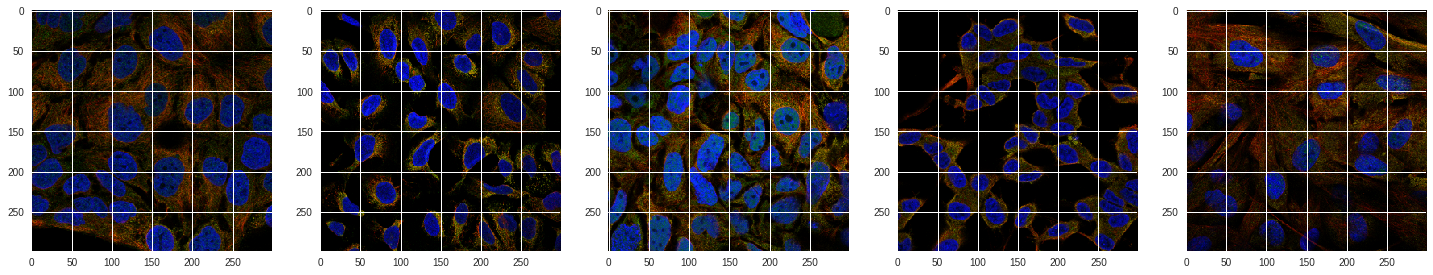

In [0]:
images, labels = next(train_datagen)

fig, ax = plt.subplots(1,5,figsize=(25,5))
for i in range(5):
    ax[i].imshow(images[i])
print('min: {0}, max: {1}'.format(images.min(), images.max()))

### Create model

In [0]:
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, load_model
from keras.layers import Activation
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Input
from keras.layers import BatchNormalization
from keras.layers import Conv2D
from keras.models import Model
from keras.applications import InceptionResNetV2
from keras.callbacks import ModelCheckpoint
from keras.callbacks import LambdaCallback
from keras.callbacks import Callback
from keras import metrics
from keras.optimizers import Adam 
from keras import backend as K
import tensorflow as tf
import keras

def create_model(input_shape, n_out):
    
    pretrain_model = InceptionResNetV2(
        include_top=False, 
        weights='imagenet', 
        input_shape=input_shape)    
    
    input_tensor = Input(shape=input_shape)
    bn = BatchNormalization()(input_tensor)
    x = pretrain_model(bn)
    x = Conv2D(128, kernel_size=(1,1), activation='relu')(x)
    x = Flatten()(x)
    x = Dropout(0.5)(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)
    output = Dense(n_out, activation='sigmoid')(x)
    model = Model(input_tensor, output)
    
    return model

Using TensorFlow backend.


In [0]:
def f1(y_true, y_pred):
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.is_nan(f1), tf.zeros_like(f1), f1)
    return K.mean(f1)

In [0]:
def show_history(history):
    fig, ax = plt.subplots(1, 3, figsize=(15,5))
    ax[0].set_title('loss')
    ax[0].plot(history.epoch, history.history["loss"], label="Train loss")
    ax[0].plot(history.epoch, history.history["val_loss"], label="Validation loss")
    ax[1].set_title('f1')
    ax[1].plot(history.epoch, history.history["f1"], label="Train f1")
    ax[1].plot(history.epoch, history.history["val_f1"], label="Validation f1")
    ax[2].set_title('acc')
    ax[2].plot(history.epoch, history.history["acc"], label="Train acc")
    ax[2].plot(history.epoch, history.history["val_acc"], label="Validation acc")
    ax[0].legend()
    ax[1].legend()
    ax[2].legend()

In [0]:
keras.backend.clear_session()

model = create_model(
    input_shape=(299,299,3), 
    n_out=28)

model.summary()

219062272/219055592 [==============================] - 7s 0us/step
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 299, 299, 3)       0         
_________________________________________________________________
batch_normalization_204 (Bat (None, 299, 299, 3)       12        
_________________________________________________________________
inception_resnet_v2 (Model)  (None, 8, 8, 1536)        54336736  
_________________________________________________________________
conv2d_204 (Conv2D)          (None, 8, 8, 128)         196736    
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 8192)              0         
_________________________________________________________________
dense_1 (

### Train model

In [0]:
checkpointer = ModelCheckpoint(
    './InceptionResNetV2.model', monitor = 'val_f1',
    verbose=2, save_best_only=True)

# no data augmentation training
train_generator = data_generator.create_train(
    train_dataset_info[train_ids.index], BATCH_SIZE, INPUT_SHAPE, augument=False)
validation_generator = data_generator.create_train(
    train_dataset_info[test_ids.index], 256, INPUT_SHAPE, augument=False)

model.layers[2].trainable = False

model.compile(
    loss='categorical_crossentropy',  
    optimizer=Adam(1e-3),
    metrics=['acc', f1])

history = model.fit_generator(
    train_generator,
    steps_per_epoch=100,
    validation_data=next(validation_generator),
    epochs=1, 
    verbose=1,
    callbacks=[checkpointer])

Epoch 1/1
100/100 [==============================] - 104s 1s/step - loss: 4.6811 - acc: 0.3330 - f1: 0.0824 - val_loss: 4.7740 - val_acc: 0.4180 - val_f1: 0.0829

Epoch 00001: val_loss improved from inf to 4.77400, saving model to ./InceptionResNetV2.model


In [0]:
# To prevent error during training, custom f1 scoring object must be defined
from keras.utils.generic_utils import get_custom_objects

get_custom_objects().update({'f1': f1})

In [0]:
# Take a checkpoint model and load into keras
from keras.models import load_model
checkpointer_savepath = './InceptionResNetV2.model'
model = load_model(checkpointer_savepath)

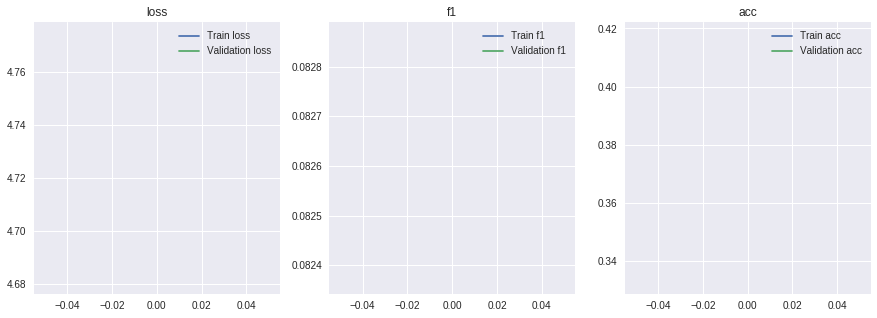

In [0]:
show_history(history)

### Bayesian Optimization

In [0]:
!pip install scikit-optimize

    100% |████████████████████████████████| 81kB 6.9MB/s 


In [0]:
from skopt.space import Real
from skopt.utils import use_named_args
from skopt import gp_minimize

def create_model_and_compile(input_shape, n_out, lr):
    """
    Args:
      input_shape: 
      n_out: number of output classes
    """
    pretrain_model = InceptionResNetV2(
        include_top=False, 
        weights='imagenet', 
        input_shape=input_shape)    
    
    input_tensor = Input(shape=input_shape)
    bn = BatchNormalization()(input_tensor)
    x = pretrain_model(bn)
    x = Conv2D(128, kernel_size=(1,1), activation='relu')(x)
    x = Flatten()(x)
    x = Dropout(0.5)(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)
    output = Dense(n_out, activation='sigmoid')(x)
    model = Model(input_tensor, output)
    
    model.layers[2].trainable = False
    model.compile(
    loss='categorical_crossentropy',  
    optimizer=Adam(lr = lr),
    metrics=['acc', f1])
    
    return model

In [0]:
path_best_model = '/content/'
best_f1 = history.history['val_f1'][-1]
dimensions = [Real(name='learning_rate', low=1e-6, high=1e-3, prior='log-uniform'),]
#           Integer(name='num_nodes', low=10, high=256),
#           Categorical(name='activation', categories=['relu', 'sigmoid'])]

In [0]:
@use_named_args(dimensions=dimensions)
def fitness(learning_rate):

    model = create_model_and_compile(input_shape = (299, 299, 3), n_out = 28, lr = learning_rate)
    
    history = model.fit_generator(
        train_generator,
        steps_per_epoch=100,
        validation_data=next(validation_generator),
        epochs=1, 
        verbose=1,
        callbacks=[checkpointer])
    
    val_f1 = history.history['val_f1'][-1]
    global best_f1

    if val_f1<best_f1:
        best_f1 = val_f1

    del model
    K.clear_session()

    return val_f1

In [0]:
history.history

{'acc': [0.3330000063031912],
 'f1': [0.0823672465607524],
 'loss': [4.681069808006287],
 'val_acc': [0.41796875424915925],
 'val_f1': [0.08286489403690211],
 'val_loss': [4.774004681035876]}

In [0]:
#running the automatic creation of models using gp_minimize and fitness function
from skopt import gp_minimize
search_result = gp_minimize(func=fitness,
                            dimensions=dimensions,
                            acq_func='EI',
                            n_calls=10,)
#                             x0=default_parameters)

Epoch 1/1
100/100 [==============================] - 157s 2s/step - loss: 4.6325 - acc: 0.2170 - f1: 0.0842 - val_loss: 4.6346 - val_acc: 0.4219 - val_f1: 0.0819

Epoch 00001: val_loss improved from 4.77400 to 4.63458, saving model to ./InceptionResNetV2.model
Epoch 1/1
100/100 [==============================] - 102s 1s/step - loss: 4.8479 - acc: 0.2980 - f1: 0.0850 - val_loss: 4.8491 - val_acc: 0.4609 - val_f1: 0.0836

Epoch 00001: val_loss did not improve from 4.63458
Epoch 1/1
100/100 [==============================] - 101s 1s/step - loss: 5.5150 - acc: 0.0620 - f1: 0.0813 - val_loss: 5.0525 - val_acc: 0.2656 - val_f1: 0.0846

Epoch 00001: val_loss did not improve from 4.63458
Epoch 1/1
100/100 [==============================] - 101s 1s/step - loss: 5.3732 - acc: 0.0980 - f1: 0.0805 - val_loss: 4.7982 - val_acc: 0.4531 - val_f1: 0.0857

Epoch 00001: val_loss did not improve from 4.63458
Epoch 1/1
100/100 [==============================] - 103s 1s/step - loss: 4.8384 - acc: 0.2820 - 

In [0]:
search_result.x

[0.000656227244977741]

### Training with Data Aug

In [0]:
# with data augmentation
train_generator = data_generator.create_train(
    train_dataset_info[train_ids.index], BATCH_SIZE, INPUT_SHAPE, augument=True)
validation_generator = data_generator.create_train(
    train_dataset_info[test_ids.index], 256, INPUT_SHAPE, augument=False)

model.layers[2].trainable = True

model.compile(
    loss='categorical_crossentropy',  
    optimizer=Adam(1e-4),
    metrics=['acc', f1])

history = model.fit_generator(
    train_generator,
    steps_per_epoch=100,
    validation_data=next(validation_generator),
    epochs=180, 
    verbose=1,
    callbacks=[checkpointer])

Epoch 1/180
100/100 [==============================] - 233s 2s/step - loss: 4.3294 - acc: 0.3900 - f1: 0.0638 - val_loss: 4.5161 - val_acc: 0.4180 - val_f1: 0.0683

Epoch 00001: val_loss did not improve from 4.11580
Epoch 2/180
100/100 [==============================] - 127s 1s/step - loss: 4.3912 - acc: 0.4040 - f1: 0.0664 - val_loss: 4.6168 - val_acc: 0.4180 - val_f1: 0.0669

Epoch 00002: val_loss did not improve from 4.11580
Epoch 3/180
100/100 [==============================] - 127s 1s/step - loss: 4.1231 - acc: 0.4170 - f1: 0.0638 - val_loss: 5.6656 - val_acc: 0.4180 - val_f1: 0.0687

Epoch 00003: val_loss did not improve from 4.11580
Epoch 4/180
100/100 [==============================] - 127s 1s/step - loss: 4.2726 - acc: 0.3960 - f1: 0.0661 - val_loss: 4.5053 - val_acc: 0.4180 - val_f1: 0.0675

Epoch 00004: val_loss did not improve from 4.11580
Epoch 5/180
100/100 [==============================] - 127s 1s/step - loss: 4.2452 - acc: 0.3980 - f1: 0.0660 - val_loss: 4.4778 - val_a

KeyboardInterrupt: ignored

In [0]:
show_history(history)

### Create submit


In [0]:
model = load_model(
    './InceptionResNetV2.model', 
    custom_objects={'f1': f1})

In [0]:
submit = pd.read_csv('./sample_submission.csv')

In [0]:
%%time
predicted = []
for name in tqdm(submit['Id']):
    path = os.path.join('./human_protein_atlas/test/', name)
    image = data_generator.load_image(path, INPUT_SHAPE)
    score_predict = model.predict(image[np.newaxis])[0]
    label_predict = np.arange(28)[score_predict>=0.2]
    str_predict_label = ' '.join(str(l) for l in label_predict)
    predicted.append(str_predict_label)

In [0]:
submit['Predicted'] = predicted
submit.to_csv('submission.csv', index=False)